<a href="https://colab.research.google.com/github/RLWH/reinforcement-learning-notebook/blob/master/Ch4%20Model-Free/Ch4_Solving_Blackjack_by_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ch4 Monte Carlo

It is not always that we can know everything in the environment, and most of the times the transitions between states could be unknown. In these cases, it is not possible to use dynamic progamming to solve the problem.

Monte Carlo methods are ways of solving these RL problems based on average sample returns. The only condition that is required by Monte Carlo methods is the task has to be episodic, which means for each task there must be a termination state. 

With this assumption, Monte Carlo methods can be incremental in an episode-by-episode sense, but not in a step-by-step sense. For simplicity, we consider only averaging complete returns.

Monte Carlo methods sample and average *returns* for each state-action pairs. The returns after taking an action in one state depends on the actions taken in later states in the same episode --> The problem is non-stationary

#### Objective of the chapter
1. MDP is not fully known, we need to make approximations on values
2. One of the way of making approximation is learning from experiences
3. The central thought of Monte Carlo is to make approximation on values by the experiences that the agent has learnt

## Monte Carlo Predictions

#### The idea of Monte Carlo methods in simple terms:  
Instead of having the expected value at each of state provided by the environment, we estimate the state value by simply averaging the returns observed after visits to that state.  
As more returns are observed, the average should converge to the expected value. 

For example, we wish to estimate $v_{\pi}(s)$, given a set of episodes obtained by folowing $\pi$ and passing through $s$. 

For each occurence of state $s$ in an episode is called a visit to $s$. $s$ may be visited multiple times in the same episode, but let's denote the first time of occurance the *first-visit* to $s$. 

#### First-visit MC method and Every-visit MC method

The *first-visit* MC method estimates $v_{\pi}(s)$ as the average of the returns following first visits to $s$, whereas the *every-visit* MC method averages the returns following all visits to $s$. 


#### Convergence and properties of MC methods

- Both first-visit MC and every-visit MC converge to $v_{\pi}(s)$ as the number of visits to $s$ approaches to infinity. (By law of large numbers)
- Each average is itself an unbiased estimate, and the standard deviation of its error falls as $1/\sqrt{n}$, where $n$ is the number of returns averaged.

## Monte Carlo Demonstration with BlackJack

### Environment Setup
Source code of the BlackJack environment [Source](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py)


#### Simple blackjack environment  
Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.   
They're playing against a fixed dealer.

- Face cards (Jack, Queen, King) have point value 10.   
   Aces can either count as 11 or 1, and it's called 'usable' at 11.  

- This game is placed with an infinite deck (or with replacement).  
- The game starts with each (player and dealer) having one face up and one face down card.

- The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).

- After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater.  If the dealer goes bust the player wins.

- If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21.   

- The reward for winning is +1, drawing is 0, and losing is -1.

The observation of a 3-tuple of: the players current sum,
the dealer's one showing card (1-10 where 1 is ace),
and whether or not the player holds a usable ace (0 or 1).

This environment corresponds to the version of the blackjack problem
described in Example 5.1 in Reinforcement Learning: An Introduction
by Sutton and Barto.
http://incompleteideas.net/book/the-book-2nd.html



#### Writing the game in MDP

Playing bllackjack is naturally formulated as an episodic finite MDP. Each game of blackjack is an episode

- Rewards: +1, -1, and 0 are given for winning, losing and drawing, respecrively
- No discounting ($\gamma = 1$), thus rewards at terminal state are also the returns
- Action: To hit, or to stick
- States: Depend on the player's cards and the dealer's showing card
   - 200 states in total (10 x 10 x 2 (Usable Ace, Not usable Ace))

Assume that cards are dealt from an infinite deck (i.e. with replacement) so that there is no advantage for card counting.

Note: The player makes decision on the basis of three variables: 
1. His current sum (12 - 21)
2. The dealer's one showing card (A - 10)
3. Whether or not he holds a usable ace

In [0]:
import gym

from gym.envs.toy_text.blackjack import BlackjackEnv

In [0]:
env = BlackjackEnv()

In [0]:
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
          score, usable_ace, dealer_score))

In [0]:
def strategy(observation):
  """If score < 20 hit else stick. Return action 0 or 1"""
  # Observation is a 3-tuple of score, dealer score and usable ace
  score, dealer_score, usable_ace = observation
  # Stick (action 0) if the score is > 20, hit (action 1) otherwise
  return 0 if score >= 20 else 1

In [59]:
for i_episode in range(1):
    observation = env.reset()
    for t in range(100):
        print_observation(observation)
        action = strategy(observation)
        print("Taking action: {}".format( ["Stick", "Hit"][action]))
        observation, reward, done, _ = env.step(action)
        if done:
            print_observation(observation)
            print("Game end. Reward: {}\n".format(float(reward)))
            break

Player Score: 12 (Usable Ace: False), Dealer Score: 5
Taking action: Hit
Player Score: 22 (Usable Ace: False), Dealer Score: 5
Game end. Reward: -1.0



#### Plotting script

In [0]:
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [0]:
%matplotlib inline

In [0]:
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

## Approximate the value function by Monte Carlo

#### First-visit MC algorithm
Input: a policy $\pi$ to be evaluated
Initialize:
> Arbitrarily initialise a value function for all states - $V(s) \in \mathop{\mathbb{R}}$, arbitrarily, for all $s \in S$  
> Initialise an empty return list for all states - $\text{Returns}(s)$ <- an empty list, for all $s \in S$

Loop forever (for each episode):
> Generate an episode following $\pi$: $S_0, A_0, R_1, S_1, A_1, R_2, ..., S_{T-1}, A_{T-1}, R_T$  
> Assign G = 0
> Loop for each step of episode, $t = T-1, T-2, ..., 0$
>> $G = \gamma G + R_{t+1}$
>> Unless $S_t$ appears in $S_0, S_1, ..., S_{t-1}$:
>>> Append $G$ to $\text{Returns}(S_t)$  
>>> $V(S_t)$ = $\text{AVG}(\text{Returns}(S_t))$


#### Incremental Monte Carlo updates

- Update $V(s)$ incrementally after episode $S_1, A_1, R_2, ..., S_T$
- For each state $S_t$ with return $G_t$
> - $N(S_t) = N(S_t) + 1$
> - $V(S_t) = V(S_t) + \frac{1}{N(S_t)} (G_t - V(S_t))$


In non-stationary problem, we can use to track a running mean
- $V(S_t) = V(S_t) + \alpha (G_t - V(S_t))$

In [0]:
from collections import defaultdict

In [0]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0, verbose=False):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # Use incremental mean
    num_state_visits = defaultdict(int)
    
    # The final value function
    V = defaultdict(float)
    
    for i in range(num_episodes):
      
      # Generate an episode
      observation = env.reset()
      
      first_observation = observation
      
      while True:  
#         print_observation(observation)
        action = policy(observation)
#         print("Taking action: {}".format( ["Stick", "Hit"][action]))
        observation, reward, done, _ = env.step(action)
      
        if done:
#             print_observation(observation)
#             print("Game end. Reward: {}\n".format(float(reward)))
            if first_observation[0] >= 12:
              num_state_visits[first_observation] += 1
              V[first_observation] = (V[first_observation]
                                + ((1/num_state_visits[first_observation]) * (discount_factor * reward - V[first_observation])))
            break
  
      if i % 5000 == 0 and verbose == True:
        print("Finished %d episodes" % (i))        
        print("State visits: ", num_state_visits)
        print("Values of each state: ", V)

    return V

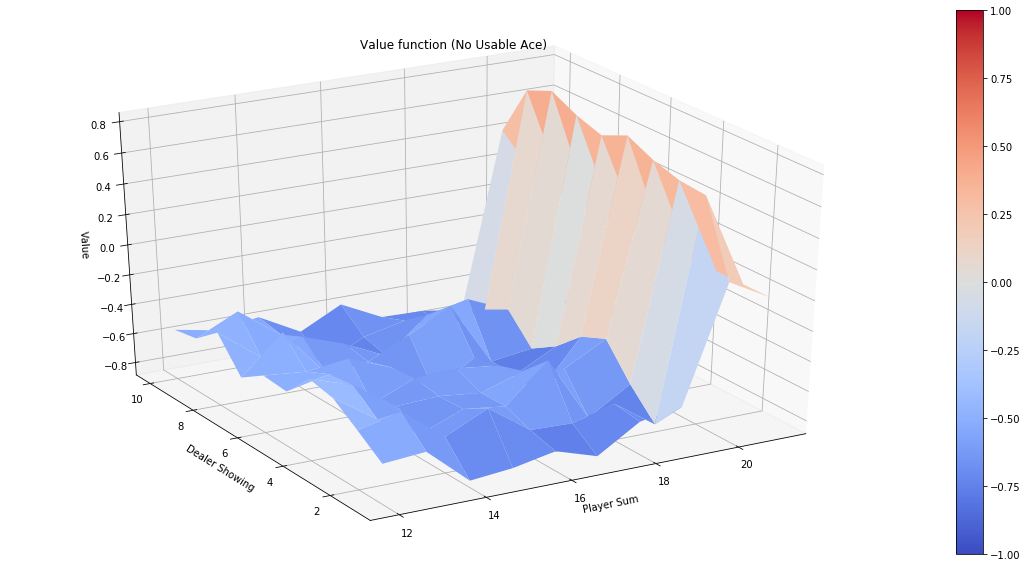

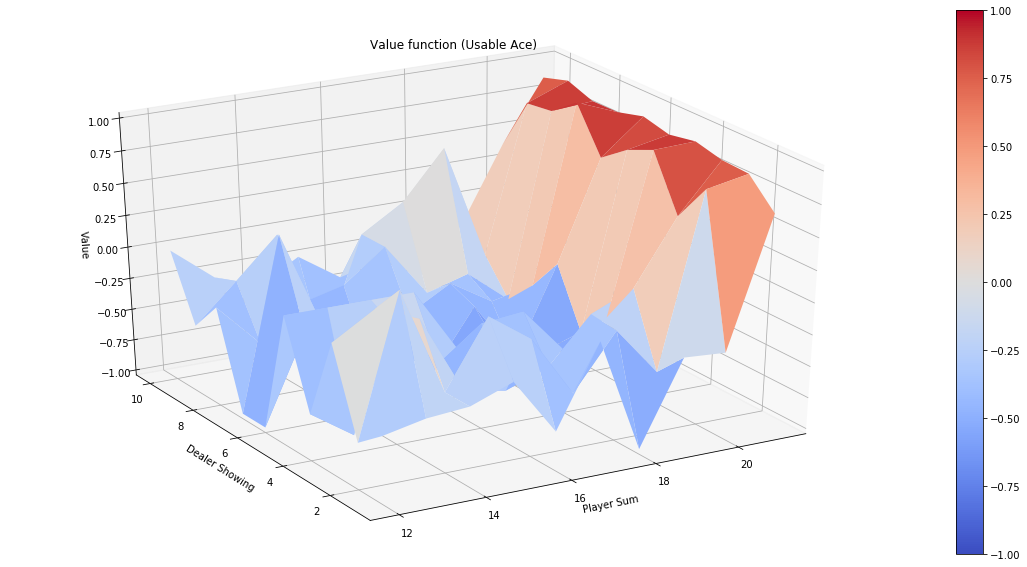

In [91]:
v_10k = mc_prediction(strategy, env, num_episodes=10000)
plot_value_function(v_10k, title="Value function")

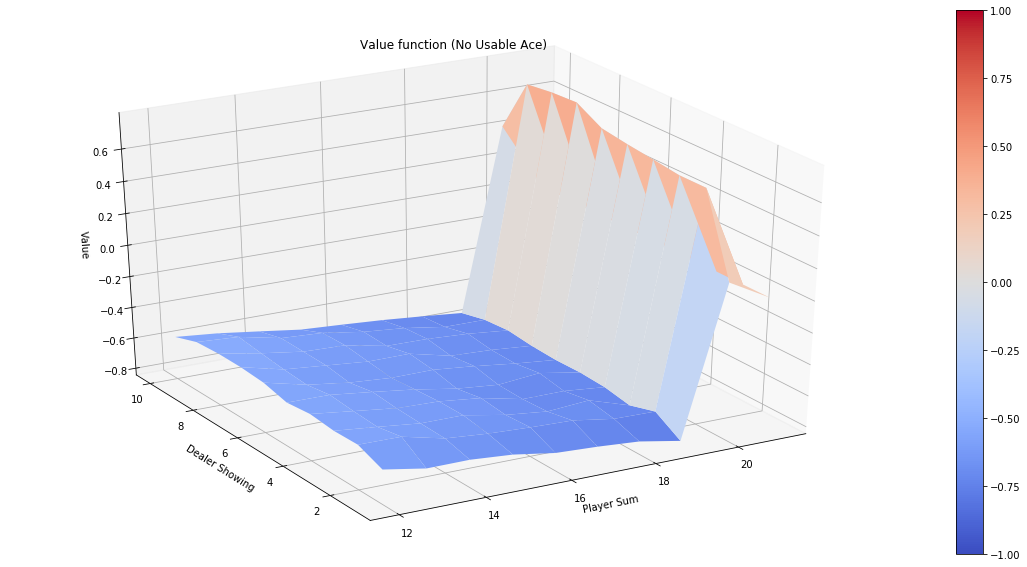

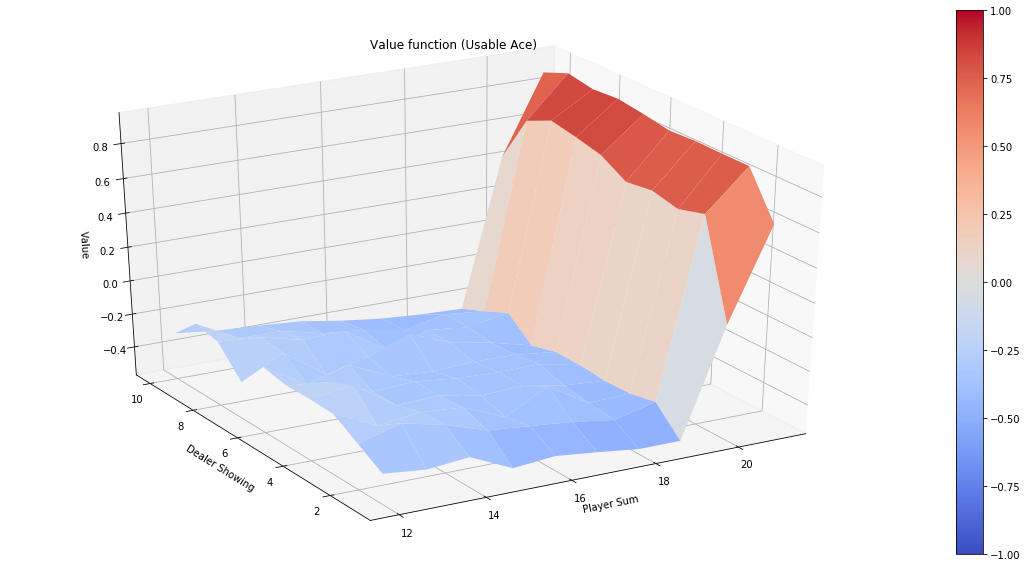

In [92]:
v_500k = mc_prediction(strategy, env, num_episodes=500000)
plot_value_function(v_500k, title="Value function")